In [23]:
import numpy as np
import sklearn.preprocessing
import torch
import pyro.distributions.transforms as T
from torch import nn
import pyro.distributions as dist
import math
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from typing import Iterable

In [24]:
M_RNG = (0.2, 100)
Q_RNG = (0.1, 0.99)


In [25]:


def load_data(path):
    data = np.load(path)
    m1 = data["m1"]
    m1 = m1.clip(*M_RNG)

    m2 = data["m2"]
    m2 = m2.clip(*M_RNG)

    q = m2 / m1
    q = q.clip(*Q_RNG)
    return m1, q


class M1QDataset(torch.utils.data.TensorDataset):
    dimensionality = 2
    has_normalization = True

    n_grid = 1024
    grid_m1 = np.linspace(*M_RNG, n_grid)
    grid_q = np.linspace(*Q_RNG, n_grid)
    grid = {
        "m1": grid_m1,
        "q": grid_q,
    }

    q_normalizer = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
    m1_normalizer = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

    def __init__(
        self,
        path,
        fold=0,
        test_size=0.0,
        limit_samples=0,
        hierarchical=True,
        n_folds=5,
    ):

        self.hierarchical = hierarchical
        m1, q = load_data(path)

        if not hierarchical:
            raise NotImplementedError

        m1, q = self.normalize_forward(m1, q)

        data = torch.from_numpy(np.stack([m1, q], axis=-1)).float().permute(1, 0, 2)

        if limit_samples > 0:
            data = data[:limit_samples]

        super().__init__(data)

    def normalize_forward(self, m1, q):
        q = 1 / q - 1
        m1 = np.log(m1)
        q = np.log(q)
        m1 = self.m1_normalizer.fit_transform(m1.reshape(-1, 1)).reshape(m1.shape)
        q = self.q_normalizer.fit_transform(q.reshape(-1, 1)).reshape(q.shape)
        return m1, q

    def normalize_inverse(self, m1, q):
        q = self.q_normalizer.inverse_transform(q.reshape(-1, 1)).reshape(q.shape)
        m1 = self.m1_normalizer.inverse_transform(m1.reshape(-1, 1)).reshape(m1.shape)
        q = np.exp(q)
        m1 = np.exp(m1)
        q = 1 / (q + 1)

        return m1, q


In [26]:
dataset = M1QDataset('../datasets/Combined_GWTC_m1m2chieffz.npz')

In [28]:
_, q = load_data('../datasets/Combined_GWTC_m1m2chieffz.npz')

In [31]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

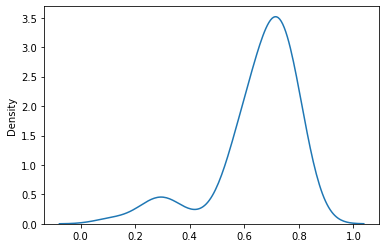

In [32]:
sns.kdeplot(q.mean(1))

In [17]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [18]:
def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
    
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y


In [19]:
class NormalizingFlow(pl.LightningModule):
    def __init__(self, flows, lr=1.0e-3, d=1):
        super().__init__()

        self.flows = flows
        self.base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
        self.lr = lr
        if isinstance(flows, Iterable):
            self.trainable_flows = nn.ModuleList(
                [flow for flow in self.flows if isinstance(flow, nn.Module)]
            )
        else:
            self.trainable_flows = flows

        self.d = d

    def parameters(self):
        return self.trainable_flows.parameters()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def step(self, batch, batch_idx):
        (x,) = batch
        lp, y = log_prob(x.view(-1, 2), transforms, base_dist)
        lp = lp.view(x.shape[:-1])
        lp = torch.logsumexp(lp, dim=0) - math.log(lp.shape[0])   
        loss = -lp.mean(0)
        
        return loss
    
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("test_loss", loss, prog_bar=True)
        return loss


class HierarchicalNormalizingFlow(NormalizingFlow):
    def __init__(self, *args, num_posterior_draws=-1, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_posterior_draws = num_posterior_draws

    def step(self, batch, batch_idx):
        (x,) = batch

        logprob, y = log_prob(x.view(-1, 2), transforms, base_dist)
        logprob = logprob.view(x.shape[:-1])
        logprob = torch.logsumexp(logprob, dim=-1) - math.log(logprob.shape[-1])    

        return -logprob.mean(0)


In [20]:
d = 2
n_layers = 8

transforms = []
for _ in range(n_layers):
    transforms.append(T.planar(d))
    transforms.append(T.permute(d, permutation=torch.tensor([1, 0])))
# transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

base_dist = dist.Normal(0, 1)

In [21]:
flow = NormalizingFlow(transforms, d=2)

step: 0, loss: 0.28277650475502014


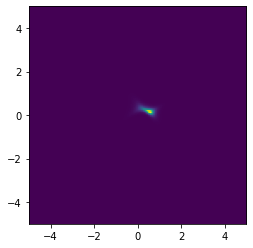

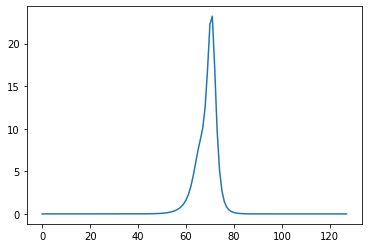

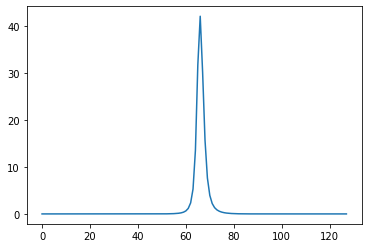

step: 1, loss: 0.164100781083107


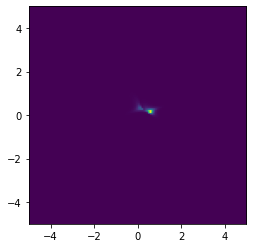

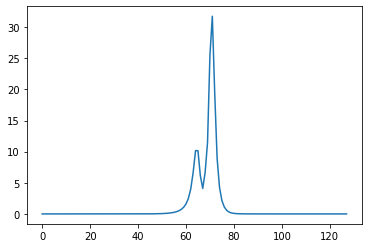

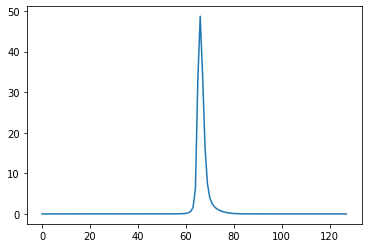

step: 2, loss: 0.04067039117217064


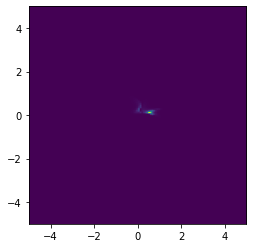

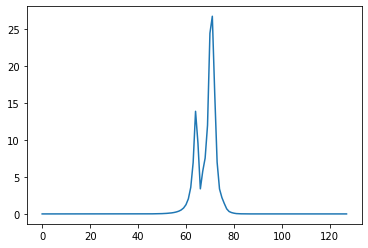

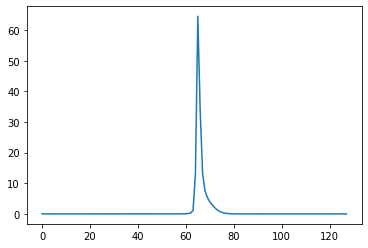

step: 3, loss: 0.036065634340047836


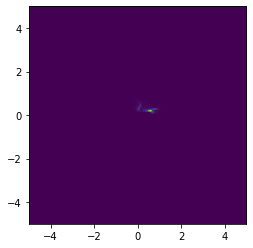

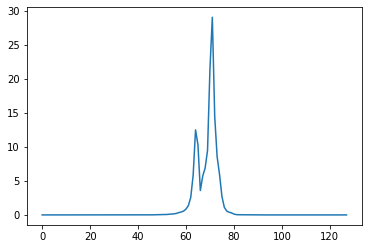

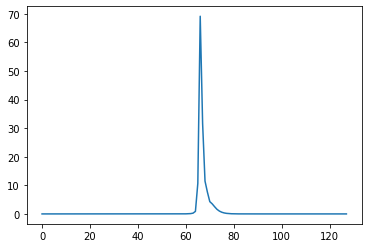

step: 4, loss: 0.04081806167960167


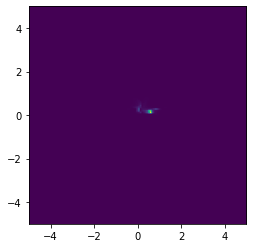

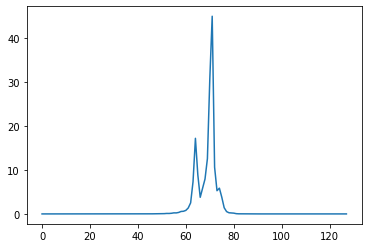

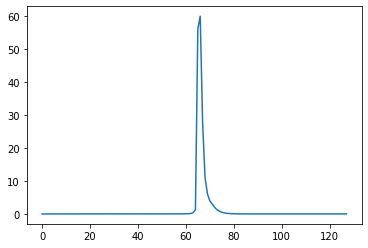

step: 5, loss: 0.0030716038309037685


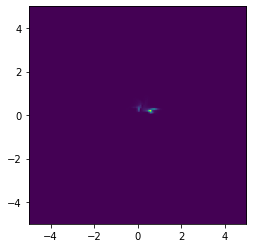

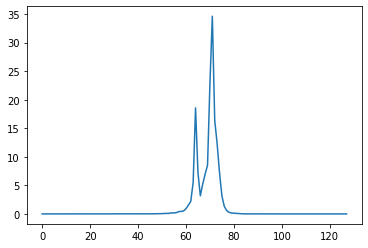

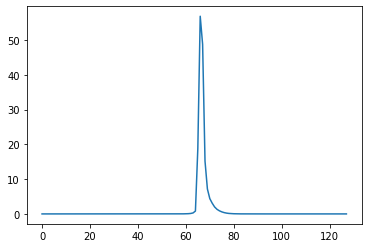

step: 6, loss: -0.08338961750268936


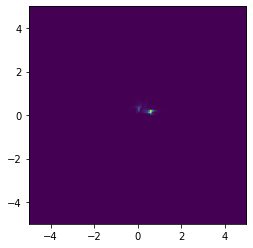

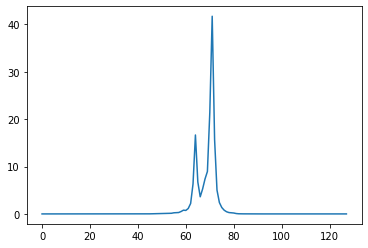

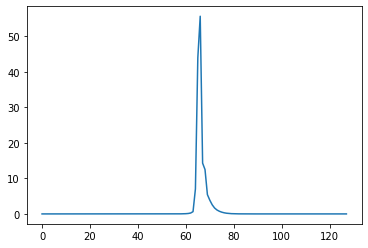

step: 7, loss: 0.01775885745882988


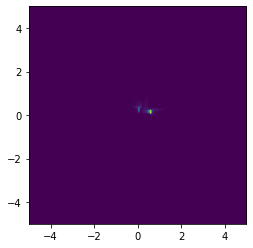

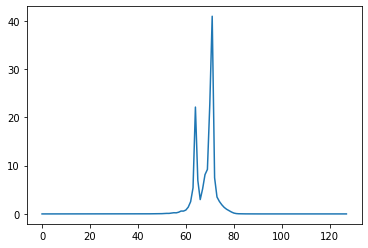

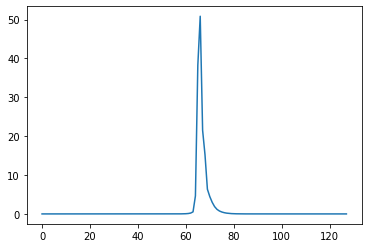

step: 8, loss: -0.031761616468429565


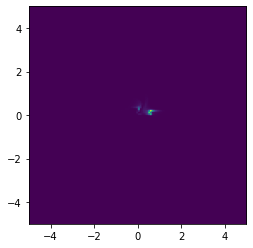

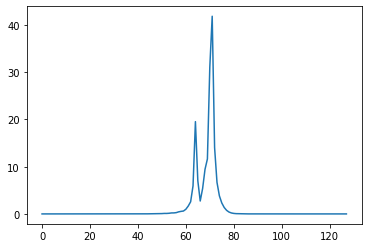

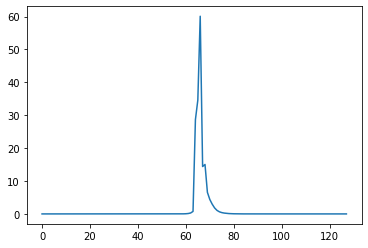

In [22]:
def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
    
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y

steps = 8
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
for step in range(steps+1):    
    for batch in train_loader:
    
    #     batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
    #     print(dataset_2d.shape)
    #     lp, y = log_prob(batch, transforms, base_dist)
#         lp, y = log_prob(batch.view(-1, 2), transforms, base_dist)
#         lp = lp.view(batch.shape[:-1])

#         lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    

#         loss = -lp.mean()
        
        loss = flow.step(batch, None)
        
    
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    print('step: {}, loss: {}'.format(step, loss.item()))
    with torch.no_grad():
        x = torch.linspace(-5, 5, 128)
        xx, yy = torch.meshgrid(x, x, indexing='xy')
        grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
        lp, y = log_prob(grid, transforms, base_dist)
        p = lp.exp().view(128, 128)
        plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
        plt.show()

        plt.plot(p.sum(0))
        plt.show()
        plt.plot(p.sum(1))
        plt.show()
